In [115]:
import glob, os

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import cv2

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

### Import feature dataset from PG

In [116]:
localhost = {'user': 'postgres', 'password': 'postgres', 'host': 'localhost', 'port': 5432, 'db': 'fiadb'}
params = 'postgresql://{0}:{1}@{2}:{3}/{4}'
engine = create_engine(params.format(localhost['user'], localhost['password'], localhost['host'], localhost['port'], localhost['db']))
# geom_sql = """select distinct grid_id, grid_geom from fs_fiadb.pergrid"""
pergrid_base = """select distinct * from predictor.pergrid_base limit 100"""
pergrid_base_df = pd.read_sql(pergrid_base, engine)
print(pergrid_base_df.shape)
df = pergrid_base_df.dropna()
df.set_index('grid_id', inplace=True)
print(df.shape)

(100, 22)
(70, 21)


In [117]:
df.head()

,aet,ai,art,ewd,fa,map,mat,mpdq,mtcq,pet,...,ra,rmap,rmat,tsn,mfdf,alt,hydrogroup,mtwq,wkb_geometry,tsr
grid_id,,,,,,,,,,,,,,,,,,,,,
111,65535.0,0.3829,20.233612,-2.537902e+06,14.1498,699.0,20.298634,92.0,16.340292,1811.927757,...,14.0,2.000000,0.620833,444.259982,2.10,5.982890,C,28.717458,0103000020AD100000010000000500000019FF84D9F561...,2.0
338,5645.0,0.3017,23.526261,-2.959517e+06,10.0350,580.0,20.710174,80.0,15.754000,1928.968811,...,34.0,3.416667,0.620833,489.587254,2.12,32.270955,C,29.300416,0103000020AD100000010000000500000099D4584CD794...,1.0
339,5485.0,0.3223,22.531334,-2.699554e+06,5.2623,604.0,20.032028,82.0,15.824125,1892.928983,...,21.0,3.583333,0.412500,462.269606,2.12,24.280230,D,28.991750,0103000020AD1000000100000005000000EE9507652C88...,2.0
340,5537.0,0.3512,22.084950,-2.606306e+06,10.9764,649.0,19.941757,90.5,15.871167,1857.342308,...,26.0,5.083333,0.437500,455.940181,1.88,17.909615,D,28.769584,0103000020AD10000001000000050000001932A436817B...,2.0
342,6297.0,0.3959,20.948348,-2.599261e+06,13.9572,702.0,20.558312,102.0,15.908917,1783.513462,...,10.0,1.750000,0.508333,464.856812,2.31,5.236538,B,28.530042,0103000020AD100000010000000500000082B350102A62...,2.0


In [118]:
inputPath = '/Users/lianfeng/Document/species_richness_sdm/src/notebooks/machine_learning/nlcd_jpg'

In [123]:
images = []
for i in df.index.values:
    # find the four images for the house and sort the file paths,
    # ensuring the four are always in the *same order*
    # basePath = os.path.sep.join([inputPath, "{}_*".format(i + 1)])
    imagePath = os.path.sep.join([inputPath, "nlcd_{}.jpg".format(i)])
    
    if not os.path.isfile(imagePath):  
        print("{} does not exist".format(imagePath))
    else:
        image = tf.io.read_file(imagePath)
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.image.convert_image_dtype(image, tf.float32)
        image = tf.image.resize(image, [667, 667])
        images.append(image.numpy())
images = np.array(images)

In [124]:
# images = np.array(images) / 255.0

In [125]:
split = train_test_split(df, images, test_size=0.2, random_state=42)
(trainAttrX, testAttrX, trainImagesX, testImagesX) = split

# maxTSR = trainAttrX["tsr"].max()
trainY = trainAttrX["tsr"]
testY = testAttrX["tsr"]

In [126]:
type(testImagesX)

numpy.ndarray

In [127]:
# initialize the column names of the continuous data
continuous = ['aet', 'ai', 'art', 'ewd','map', 'mat', 'mpdq', 'mtcq', 'pet', 'psn', 'ra', 'rmap', 'rmat', 'tsn', 'mfdf', 'alt','mtwq']

# performin min-max scaling each continuous feature column to the range [0, 1]
cs = MinMaxScaler()
trainContinuous = cs.fit_transform(trainAttrX[continuous])
testContinuous = cs.transform(testAttrX[continuous])

# one-hot encode the zip code categorical data (by definition of
# one-hot encoding, all output features are now in the range [0, 1])
zipBinarizer = LabelBinarizer().fit(df["hydrogroup"])
trainCategorical = zipBinarizer.transform(trainAttrX["hydrogroup"])
testCategorical = zipBinarizer.transform(testAttrX["hydrogroup"])

# construct training and testing data points by concatenating
# the categorical features with the continuous features
trainX = np.hstack([trainCategorical, trainContinuous])
testX = np.hstack([testCategorical, testContinuous])

### Verify the data

To verify that the dataset looks correct, let's plot the first 25 images from the training set and display the class name below each image.


In [128]:
continuous = ['aet', 'ai', 'art', 'ewd', 'fa', 'map', 'mat', 'mpdq',
       'mtcq', 'pet', 'psn', 'ra', 'rmap', 'rmat', 'tsn', 'mfdf', 'alt','mtwq']

In [129]:
len(continuous)

18

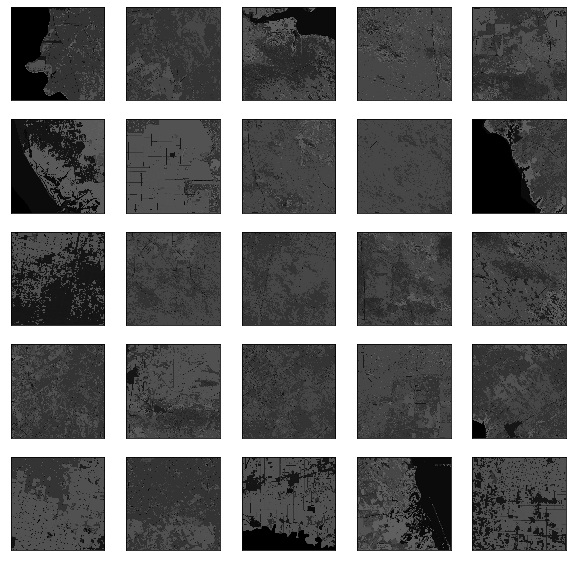

In [130]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(trainImagesX[i], cmap=plt.cm.binary)

plt.show()

In [131]:
type(trainImagesX)

numpy.ndarray

### Create the convolutional base

The 6 lines of code below define the convolutional base using a common pattern: a stack of [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) and [MaxPooling2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D) layers.

As input, a CNN takes tensors of shape (image_height, image_width, color_channels), ignoring the batch size. If you are new to these dimensions, color_channels refers to (R,G,B). In this example, you will configure our CNN to process inputs of shape (32, 32, 3), which is the format of CIFAR images. You can do this by passing the argument `input_shape` to our first layer.


In [132]:
inputShape = trainImagesX[0].shape

In [133]:
model = models.Sequential()
model.add(layers.Conv2D(filters=32, kernel_size=(5, 5), activation='relu', input_shape=inputShape))
model.add(layers.Conv2D(filters=64, kernel_size=(5, 5), strides=(2, 2), activation='relu'))
model.add(layers.Conv2D(filters=128, kernel_size=(5, 5), strides=(2, 2), activation='relu'))

Let's display the architecture of our model so far.

In [134]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 663, 663, 32)      2432      
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 330, 330, 64)      51264     
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 163, 163, 128)     204928    
Total params: 258,624
Trainable params: 258,624
Non-trainable params: 0
_________________________________________________________________


In [135]:
inputShape

(667, 667, 3)

Above, you can see that the output of every Conv2D and MaxPooling2D layer is a 3D tensor of shape (height, width, channels). The width and height dimensions tend to shrink as you go deeper in the network. The number of output channels for each Conv2D layer is controlled by the first argument (e.g., 32 or 64). Typically,  as the width and height shrink, you can afford (computationally) to add more output channels in each Conv2D layer.

### Add Dense layers on top
To complete our model, you will feed the last output tensor from the convolutional base (of shape (4, 4, 64)) into one or more Dense layers to perform classification. Dense layers take vectors as input (which are 1D), while the current output is a 3D tensor. First, you will flatten (or unroll) the 3D output to 1D,  then add one or more Dense layers on top. CIFAR has 10 output classes, so you use a final Dense layer with 10 outputs and a softmax activation.

In [136]:
model.add(layers.Flatten())
model.add(layers.Dense(1, activation='linear'))

Here's the complete architecture of our model.

In [137]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 663, 663, 32)      2432      
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 330, 330, 64)      51264     
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 163, 163, 128)     204928    
_________________________________________________________________
flatten_4 (Flatten)          (None, 3400832)           0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 3400833   
Total params: 3,659,457
Trainable params: 3,659,457
Non-trainable params: 0
_________________________________________________________________


### Compile and train the model

In [138]:
np.array(trainY)

array([ 1.,  5.,  5.,  2.,  4., 13.,  2.,  2.,  3.,  1.,  1.,  2.,  3.,
        1.,  1.,  2.,  3.,  2.,  4.,  2.,  2.,  1.,  2.,  2.,  2.,  2.,
        2.,  5.,  4.,  4.,  4.,  3.,  4.,  2.,  4., 13.,  3.,  1.,  3.,
        1.,  3.,  2., 16.,  1.,  3.,  3.,  3.,  1.,  4.,  2.,  2.,  4.,
        3., 12.,  4.,  1.])

In [139]:
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
history = model.fit(trainImagesX, np.array(trainY), epochs=3, validation_data=(testImagesX, np.array(testY)))

Train on 56 samples, validate on 14 samples
Epoch 1/3
56/56 [==============================] - 40s 714ms/sample - loss: 2542.5968 - mae: 34.1201 - val_loss: 16.9498 - val_mae: 3.1982
Epoch 2/3
56/56 [==============================] - 43s 772ms/sample - loss: 24.5323 - mae: 4.2663 - val_loss: 43.4626 - val_mae: 4.6173
Epoch 3/3
56/56 [==============================] - 33s 580ms/sample - loss: 16.4056 - mae: 2.7510 - val_loss: 92.6014 - val_mae: 9.1524


In [140]:
type(history.history['mae'])

list

### Evaluate the model

As you can see, our (4, 4, 64) outputs were flattened into vectors of shape (1024) before going through two Dense layers.

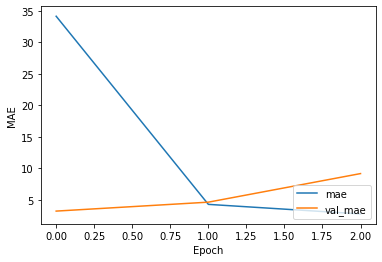

In [141]:
plt.plot(history.history['mae'], label='mae')
plt.plot(history.history['val_mae'], label = 'val_mae')
plt.xlabel('Epoch')
plt.ylabel('MAE')
# plt.ylim([0.5, 1])
plt.legend(loc='lower right')

In [142]:
tf_history = pd.DataFrame(
    {'loss': history.history['loss'],
     'mae': history.history['mae'],
     'val_loss': history.history['val_loss'],
     'val_mae': history.history['val_mae']})

In [143]:
tf_history.to_csv('./m5_base_cnn_tf_history.csv')

In [144]:
test_mse, test_mae = model.evaluate(testImagesX,  np.array(testY), verbose=2)
print(test_mse, test_mae)

14/1 - 2s - loss: 92.6014 - mae: 9.1524
92.60137176513672 9.152425


In [145]:
# test_predictions = model.predict(normed_test_data).flatten()
y_pred = model.predict(images).flatten()

In [146]:
pergrid_base_predicted = pd.DataFrame(
    {'grid_id': df.index.values,
     'tsr': df['tsr'],
     'tsr_predicted': y_pred})

In [147]:
pergrid_base_predicted

,grid_id,tsr,tsr_predicted
grid_id,,,
111,111,2.0,9.996232
338,338,1.0,8.161027
339,339,2.0,10.779520
340,340,2.0,12.743021
342,342,2.0,15.759338
...,...,...,...
1952,1952,3.0,12.710053
1953,1953,2.0,13.213342
1954,1954,3.0,14.253904
